# 1 在QA管道中使用快速tokenizer

我们现在将深入研究 question-answering 管道，看看如何利用偏移量从上下文（context）中获取当前问题的答案，这与我们在上一节中处理分组实体的方式有些相似。我们会看到如何处理那些因为过长而最终被截断的上下文（context）。

## 1.1 使用 question-answering 管道

In [1]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cpu


{'score': 0.9802603125572205,
 'start': 78,
 'end': 106,
 'answer': 'Jax, PyTorch, and TensorFlow'}

与其他不能处理超过模型接受的最大长度的文本的管道不同，这个管道可以处理非常长的上下文（context），并且即使答案在末尾也能返回问题的答案：

In [2]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9714871048927307,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

## 1.2 使用模型进行问答

与任何其他管道一样，我们首先对输入进行 tokenize，然后将其传入模型。 question-answering 管道默认情况下用于的 checkpoint 是 distilbert-base-cased-distilled-squad （名字中的”squad”源自模型微调所用的数据集）

In [3]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

请注意在这里，我们将问题放在前面和上下文放后面，一起作为一对进行tokenization。
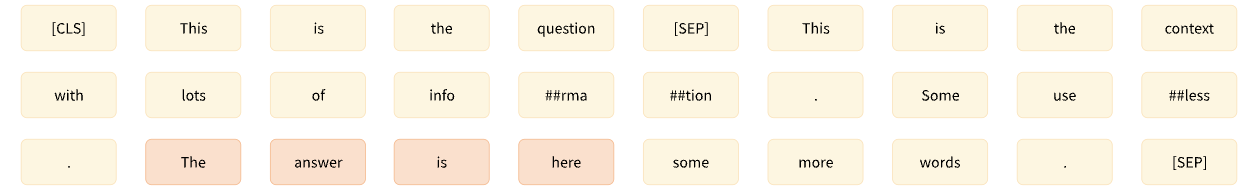

问答模型的工作方式与我们迄今为止看到的模型略有不同。以上图为例，模型训练的目标是来预测答案开始的 token 的索引（这里是 21）和答案结束的 token 的索引（这里是 24）。这就是为什么这些模型不返回一个 logits 的张量，而是返回两个：一个对应于答案的开始 token 的 logits，另一个对应于答案的结束 token 的 logits。在这个例子中，我们的输入包含了 66 个 token ，因此我们得到：

In [5]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
start_logits.shape, end_logits.shape

(torch.Size([1, 67]), torch.Size([1, 67]))

为了将这些 logits 转换为概率，我们将使用一个 softmax 函数——但在此之前，我们需要确保我们屏蔽了不属于上下文的索引。我们的输入格式是 [CLS] question [SEP] context [SEP] ，所以我们需要屏蔽 question 的 tokens 以及 [SEP] token 。不过，我们将保留 [CLS] ，因为某些模型使用它来表示答案不在上下文中。



In [6]:
inputs.sequence_ids()

[None,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 None,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 None]

In [12]:
import torch

sequence_ids = inputs.sequence_ids()
mask = [i != 1 for i in sequence_ids]

mask[0] = False
mask = torch.tensor(mask)[None]
mask.shape

torch.Size([1, 67])

In [13]:
start_logits[mask] = -10000
end_logits[mask] = -10000

现在我们已经屏蔽了与我们不想预测的位置相对应的 logits，接下来我们可以使用 softmax：

In [14]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

In [19]:
start_probabilities[:, None].shape

torch.Size([67, 1])

首先让我们计算所有可能的乘积：

In [17]:
scores = start_probabilities[:, None] * end_probabilities[None, :]
scores.shape

torch.Size([67, 67])

In [20]:
import numpy as np

scores = torch.triu(scores)

现在我们只需要得到最大值的索引。由于 PyTorch 将返回展平（flattened）后张量中的索引，因此我们需要使用向下取整的除法 // 和取模 % 操作来获得 start_index 和 end_index ：



In [29]:
scores.shape

torch.Size([67, 67])

In [41]:
max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
print(scores[start_index, end_index])

tensor(0.9803, grad_fn=<SelectBackward0>)


我们还没有完全完成，但至少我们已经有了正确的答案分数（你可以通过将其与上一节中的第一个结果进行比较来检查这一点）：

✏️ 试试看！ 计算五个最可能的答案的开始和结束索引。

In [31]:
flat_scores = scores.flatten()

In [38]:
max_indices = torch.topk(flat_scores, k=5).indices.tolist()
for index in max_indices:
  start_index = index // scores.shape[1]
  end_index = index % scores.shape[1]
  print(scores[start_index, end_index])

tensor(0.9803, grad_fn=<SelectBackward0>)
Jax, PyTorch, and TensorFlow
tensor(0.0082, grad_fn=<SelectBackward0>)
Jax, PyTorch, and TensorFlow —
tensor(0.0068, grad_fn=<SelectBackward0>)
three most popular deep learning libraries — Jax, PyTorch, and TensorFlow
tensor(0.0014, grad_fn=<SelectBackward0>)
Jax, PyTorch
tensor(0.0004, grad_fn=<SelectBackward0>)
PyTorch, and TensorFlow


我们有了答案的 start_index 和 end_index ，所以现在我们只需要将他们转换为上下文中的字符索引。这就是偏移量将会非常有用的地方。我们可以像我们在 token 分类任务中那样获取偏移量并使用它们：

In [43]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]
answer

'Jax, PyTorch, and TensorFlow'

In [44]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
result

{'answer': 'Jax, PyTorch, and TensorFlow',
 'start': 78,
 'end': 106,
 'score': tensor(0.9803, grad_fn=<SelectBackward0>)}

✏️ 试试看！ 使用你之前计算的最佳分数来显示五个最可能的答案。你可以回到之前的 QA pipeline，并在调用时传入 top_k=5 来对比检查你的结果。

In [45]:
max_indices = torch.topk(flat_scores, k=5).indices.tolist()
ans = []
for index in max_indices:
  start_index = index // scores.shape[1]
  end_index = index % scores.shape[1]
  start_char, _ = offsets[start_index]
  _, end_char = offsets[end_index]
  answer = context[start_char:end_char]
  ans.append({
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
})

ans

[{'answer': 'Jax, PyTorch, and TensorFlow',
  'start': 78,
  'end': 106,
  'score': tensor(0.9803, grad_fn=<SelectBackward0>)},
 {'answer': 'Jax, PyTorch, and TensorFlow —',
  'start': 78,
  'end': 108,
  'score': tensor(0.0082, grad_fn=<SelectBackward0>)},
 {'answer': 'three most popular deep learning libraries — Jax, PyTorch, and TensorFlow',
  'start': 33,
  'end': 106,
  'score': tensor(0.0068, grad_fn=<SelectBackward0>)},
 {'answer': 'Jax, PyTorch',
  'start': 78,
  'end': 90,
  'score': tensor(0.0014, grad_fn=<SelectBackward0>)},
 {'answer': 'PyTorch, and TensorFlow',
  'start': 83,
  'end': 106,
  'score': tensor(0.0004, grad_fn=<SelectBackward0>)}]

In [46]:
question_answerer(question=question, context=context, top_k=5)

[{'score': 0.9802603125572205,
  'start': 78,
  'end': 106,
  'answer': 'Jax, PyTorch, and TensorFlow'},
 {'score': 0.00824777316302061,
  'start': 78,
  'end': 108,
  'answer': 'Jax, PyTorch, and TensorFlow —'},
 {'score': 0.0013676955131813884,
  'start': 78,
  'end': 90,
  'answer': 'Jax, PyTorch'},
 {'score': 0.00038108445005491376,
  'start': 83,
  'end': 106,
  'answer': 'PyTorch, and TensorFlow'},
 {'score': 0.00021684484090656042,
  'start': 96,
  'end': 106,
  'answer': 'TensorFlow'}]

## 1.3 处理长文本

如果我们尝试将我们之前使用的长问题和长上下文进行 tokenize，我们将得到一个比 question-answering pipeline 中使用的最大长度（384）更大的 tokens 数量：

In [47]:
inputs = tokenizer(question, long_context)
len(inputs["input_ids"])

461

所以，我们需要将我们的输入截断到模型允许输入的最大长度。我们可以用几种方式做到这一点，但我们不想截断问题部分，只想截断上下文部分，并且由于上下文部分是第二项，因此我们将使用 "only_second" 截断策略。

然后又出现了新的问题：问题的答案可能在截断后被丢弃了，并没有在截断后保留下来的上下文文本中。例如，我们选了一个问题，其中的答案在上下文的末尾，当我们截断它时，答案就不在里面了：

In [49]:
inputs = tokenizer(question, long_context, max_length=384, truncation="only_second")
tokenizer.decode(inputs["input_ids"])

"[CLS] Which deep learning libraries back [UNK] Transformers? [SEP] [UNK] Transformers : State of the Art NLP [UNK] Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation and more in over 100 languages. Its aim is to make cutting - edge NLP easier to use for everyone. [UNK] Transformers provides APIs to quickly download and use those pretrained models on a given text, fine - tune them on your own datasets and then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments. Why should I use transformers? 1. Easy - to - use state - of - the - art models : - High performance on NLU and NLG tasks. - Low barrier to entry for educators and practitioners. - Few user - facing abstractions with just three classes to learn. - A unified 

这意味着模型将很难找到正确的答案。为了解决这个问题， question-answering 管道允许我们将上下文分成更小的块，指定最大长度。为了确保我们不在刚好可能找到答案的地方将上下文分割，它还在各块之间包含了一些重叠。

我们可以通过添加 return_overflowing_tokens=True 参数，并可以用 stride 参数指定我们想要的重叠长度来让 tokenizer （快速或慢速）为我们做这个工作。下面是一个使用较短的句子的例子：

In [50]:
sentence = "This sentence is not too long but we are going to split it anyway."
inputs = tokenizer(
    sentence, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] This sentence is not [SEP]
[CLS] is not too long [SEP]
[CLS] too long but we [SEP]
[CLS] but we are going [SEP]
[CLS] are going to split [SEP]
[CLS] to split it anyway [SEP]
[CLS] it anyway. [SEP]


In [51]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])

正如我们所预期的，我们得到了inputs ID 和注意力掩码。最后一个键，overflow_to_sample_mapping，是一个映射，告诉我们每个结果对应哪个句子——在这里，我们有 7 个结果，它们都来自我们传递给 tokenizer 的（唯一的）句子：

In [52]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0, 0, 0, 0]

当我们一起对多个句子 tokenize 时，这会更有用。例如，这个：

In [53]:
sentences = [
    "This sentence is not too long but we are going to split it anyway.",
    "This sentence is shorter but will still get split.",
]
inputs = tokenizer(
    sentences, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


现在让我们回到我们的长上下文。默认情况下， question-answering pipeline 使用我们之前提到的 384 作为最大长度，步长为 128，这与模型的微调方式相对应（你可以通过在调用 pipeline 时传递 max_seq_len 和 stride 参数来调整这些参数）。因此，我们在 tokenization 时将使用微调时使用的这些参数。我们还会添加填充（使样本具有相同的长度，这样我们就可以构建拼接成一个矩形的张量），并获取偏移量：

In [57]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    padding="longest",
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True
)
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [58]:
_ = inputs.pop("overflow_to_sample_mapping")
offsets = inputs.pop("offset_mapping")

inputs = inputs.convert_to_tensors("pt")
print(inputs["input_ids"].shape)

torch.Size([2, 384])


In [59]:
for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] Which deep learning libraries back [UNK] Transformers? [SEP] [UNK] Transformers : State of the Art NLP [UNK] Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation and more in over 100 languages. Its aim is to make cutting - edge NLP easier to use for everyone. [UNK] Transformers provides APIs to quickly download and use those pretrained models on a given text, fine - tune them on your own datasets and then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments. Why should I use transformers? 1. Easy - to - use state - of - the - art models : - High performance on NLU and NLG tasks. - Low barrier to entry for educators and practitioners. - Few user - facing abstractions with just three classes to learn. - A unified A

我们的长上下文被分成两部分，这意味着在经过我们的模型后，我们将得到两组开始和结束的 logits：

In [60]:
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([2, 384]) torch.Size([2, 384])


和以前一样，我们在计算 softmax 之前屏蔽不属于上下文的 token 。我们还屏蔽了所有填充 token （如注意力掩码）：

In [61]:
sequence_ids = inputs.sequence_ids()
# 屏蔽除 context tokens 之外的所有内容
mask = [i != 1 for i in sequence_ids]
# 取消对 [CLS] token 的屏蔽
mask[0] = False
# 屏蔽所有的 [PAD] tokens
mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))

start_logits[mask] = -10000
end_logits[mask] = -10000

In [62]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

下一步与我们对短的上下文所做的类似，但在这里我们将对两个块分别进行处理。我们为所有可能的回答范围赋予一个得分，然后选择得分最高的范围：

In [63]:
candidates = []
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
    scores = start_probs[:, None] * end_probs[None, :]
    idx = torch.triu(scores).argmax().item()

    start_idx = idx // scores.shape[1]
    end_idx = idx % scores.shape[1]
    score = scores[start_idx, end_idx].item()
    candidates.append((start_idx, end_idx, score))

print(candidates)

[(0, 18, 0.33866992592811584), (173, 184, 0.9714868664741516)]


这两个候选范围对应的是模型在每个块中能够找到的最好的答案。模型对于正确的答案在第二部分更有信心（这是个好兆头！）。现在我们只需要将这两个 token 范围映射到上下文中的字符范围（我们只需要映射第二个就能得到我们的答案，但是看看模型在第一块中选取了什么作为答案还是很有意思的）。

我们之前抓取 offsets 的实际上是一个偏移量列表，每个文本块都有一个列表：



In [64]:
for candidate, offset in zip(candidates, offsets):
    start_token, end_token, score = candidate
    start_char, _ = offset[start_token]
    _, end_char = offset[end_token]
    answer = long_context[start_char:end_char]
    result = {"answer": answer, "start": start_char, "end": end_char, "score": score}
    print(result)

{'answer': '\n🤗 Transformers: State of the Art NLP', 'start': 0, 'end': 37, 'score': 0.33866992592811584}
{'answer': 'Jax, PyTorch and TensorFlow', 'start': 1892, 'end': 1919, 'score': 0.9714868664741516}


In [65]:
question_answerer(question=question, context=long_context, top_k=5)

[{'score': 0.9714871048927307,
  'start': 1892,
  'end': 1919,
  'answer': 'Jax, PyTorch and TensorFlow'},
 {'score': 0.14949452877044678,
  'start': 17,
  'end': 37,
  'answer': 'State of the Art NLP'},
 {'score': 0.015565173700451851,
  'start': 1892,
  'end': 1921,
  'answer': 'Jax, PyTorch and TensorFlow —'},
 {'score': 0.013705423101782799, 'start': 34, 'end': 37, 'answer': 'NLP'},
 {'score': 0.010596777312457561,
  'start': 3,
  'end': 37,
  'answer': 'Transformers: State of the Art NLP'}]